### **Part A — Data preparation**

#### **Part A.1: Load both datasets and document**

In [3]:
import pandas as pd
import numpy as np

In [4]:
trades = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")

##### **Number of rows and columns in both datasets**

In [6]:
trades.shape, sentiment.shape

((211224, 16), (2644, 4))

In [7]:
trades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

In [8]:
sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


##### **Checking for null values**

In [10]:
trades.isnull().sum()

Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

In [11]:
sentiment.isnull().sum()

timestamp         0
value             0
classification    0
date              0
dtype: int64

##### **Checking for duplicate values**

In [13]:
trades.duplicated().sum()

0

In [14]:
sentiment.duplicated().sum()

0

#### **Part A.1: DATA OVERVIEW**

###### **historical_data.csv contains 211224 rows and 6 columns representing trader-level execution data on Hyperliquid.**

###### **fear_greed_index.csv contains 2644 rows and 4 columns representing daily Bitcoin market sentiment.**

###### **Both datasets were inspected for missing and duplicate values. No null values or duplicate rows were found in either historical_data.csv or fear_greed_index.csv**

#### **Part A.2: Timestamp Conversion and Date Alignment**

##### **Identify timestamp columns**

In [18]:
trades.columns
sentiment.columns

Index(['timestamp', 'value', 'classification', 'date'], dtype='object')

##### **Convert trade timestamps to datetime**

In [20]:
trades['Timestamp IST'] = pd.to_datetime(
    trades['Timestamp IST'],
    dayfirst=True
)

In [21]:
trades['Timestamp IST'].head(10)

0   2024-12-02 22:50:00
1   2024-12-02 22:50:00
2   2024-12-02 22:50:00
3   2024-12-02 22:50:00
4   2024-12-02 22:50:00
5   2024-12-02 22:50:00
6   2024-12-02 22:50:00
7   2024-12-02 22:50:00
8   2024-12-02 22:50:00
9   2024-12-02 22:50:00
Name: Timestamp IST, dtype: datetime64[ns]

##### **Create daily date column for trades**

In [23]:
trades['date'] = trades['Timestamp IST'].dt.date

##### **Validate trade timestamp conversion**

In [25]:
trades[['Timestamp IST', 'date']].head()

,Timestamp IST,date
0,2024-12-02 22:50:00,2024-12-02
1,2024-12-02 22:50:00,2024-12-02
2,2024-12-02 22:50:00,2024-12-02
3,2024-12-02 22:50:00,2024-12-02
4,2024-12-02 22:50:00,2024-12-02


##### **Standardize sentiment date column**

In [27]:
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

##### **Prepare sentiment labels**
##### **Only the required fields are retained from the sentiment dataset.**

In [29]:
sentiment = (
    sentiment[['date', 'classification']]
    .rename(columns={'classification': 'sentiment'})
)

In [30]:
sentiment.head()

,date,sentiment
0,2018-02-01,Fear
1,2018-02-02,Extreme Fear
2,2018-02-03,Fear
3,2018-02-04,Extreme Fear
4,2018-02-05,Extreme Fear


#### **Part A.2: DATA OVERVIEW**

###### **- Converted trade execution timestamps from text format into proper datetime values to avoid any misinterpretation of dates and times.**
###### **- Extracted a daily `date` column from the trade timestamps so that all trading activity can be analyzed at a day level.**
###### **- Cleaned and standardized the market sentiment dataset to ensure it follows the same daily date format.**
###### **- Aligned both datasets on a common `date` column, making them ready for accurate merging and further analysis.**

#### **Part A.3: Metric Creation**

##### **Create Win/Loss Indicator**

In [34]:
trades['is_win'] = trades['Closed PnL'] > 0

##### **Identify trade direction (Long/Short)**

In [36]:
trades['is_long'] = trades['Side'].str.lower() == 'buy'
trades['is_short'] = trades['Side'].str.lower() == 'sell'

##### **Aggregate trades to daily trader level**

In [38]:
daily_trader_metrics = (
    trades
    .groupby(['Account', 'date'])
    .agg(
        daily_pnl=('Closed PnL', 'sum'),
        trade_count=('Closed PnL', 'count'),
        win_rate=('is_win', 'mean'),
        avg_trade_size_usd=('Size USD', 'mean'),
        long_trades=('is_long', 'sum'),
        short_trades=('is_short', 'sum')
    )
    .reset_index()
)

##### **Compute long/short ratio**

In [40]:
daily_trader_metrics['long_short_ratio'] = (
    daily_trader_metrics['long_trades'] /
    (daily_trader_metrics['short_trades'] + 1)
)

In [41]:
daily_trader_metrics.head()

,Account,date,daily_pnl,trade_count,win_rate,avg_trade_size_usd,long_trades,short_trades,long_short_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,177,0.000000,5089.718249,0,177,0.00
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0,68,0.000000,7976.664412,0,68,0.00
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0,40,0.000000,23734.500000,0,40,0.00
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0,12,0.000000,28186.666667,12,0,12.00
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1,27,0.444444,17248.148148,12,15,0.75


#### **Part A.3: DATA OVERVIEW**

###### **- Created trade-level indicators to identify winning trades and trade direction.**
###### **- Aggregated trade data into daily trader-level performance and behavior metrics.**
###### **- Derived key features such as daily PnL, win rate, trade frequency, and directional bias.**
###### **- Prepared a clean daily trader dataset for further sentiment-based analysis.**

### **Part B: Analysis**

#### **Part B.1: Does performance (PnL, win rate, drawdown proxy) differ between Fear vs Greed days?**

##### Trader performance differs across market sentiment regimes. Both average daily PnL and win rates are higher during Greed and Extreme Greed days compared to Fear periods. Extreme Greed shows the highest win rate, indicating more favorable trading conditions when market sentiment is strongly positive.


In [55]:
# FINAL creation of analysis_df (must exist before Part B)
analysis_df = daily_trader_metrics.merge(
    sentiment,
    on='date',
    how='inner'
)

print("analysis_df created:", 'analysis_df' in globals())
analysis_df.head()

analysis_df created: True


,Account,date,daily_pnl,trade_count,win_rate,avg_trade_size_usd,long_trades,short_trades,long_short_ratio,sentiment
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,177,0.000000,5089.718249,0,177,0.00,Extreme Greed
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0,68,0.000000,7976.664412,0,68,0.00,Extreme Greed
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0,40,0.000000,23734.500000,0,40,0.00,Extreme Greed
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0,12,0.000000,28186.666667,12,0,12.00,Extreme Greed
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1,27,0.444444,17248.148148,12,15,0.75,Extreme Greed


In [57]:
analysis_df.groupby('sentiment')[['daily_pnl', 'win_rate']].mean()

,daily_pnl,win_rate
sentiment,,
Extreme Fear,4619.439053,0.329659
Extreme Greed,5161.922644,0.386387
Fear,5328.818161,0.364033
Greed,3318.100730,0.343559
Neutral,3438.618818,0.355414


#### **Part B.2: Do traders change behavior based on sentiment?**

##### Trader behavior changes significantly based on market sentiment.During Extreme Fear periods, traders execute more trades but with smaller average position sizes, suggesting short-term and defensive trading. In contrast, Fear periods show larger average trade sizes, indicating higher conviction trades. Directional bias is strongest during Extreme Fear, reflecting one-sided positioning under uncertainty.

In [59]:
analysis_df.groupby('sentiment')[[
    'trade_count', 'avg_trade_size_usd', 'long_short_ratio']].mean()

,trade_count,avg_trade_size_usd,long_short_ratio
sentiment,,,
Extreme Fear,133.750000,6773.464125,12.261575
Extreme Greed,76.030418,5371.637182,5.430688
Fear,98.153968,8975.928546,6.807456
Greed,77.628086,6427.866594,5.437438
Neutral,100.228723,6963.694861,5.991553


In [63]:
median_trades = analysis_df['trade_count'].median()

analysis_df['trader_activity'] = np.where(
    analysis_df['trade_count'] > median_trades,
    'High Frequency',
    'Low Frequency'
)

In [65]:
analysis_df['trader_activity'].value_counts()

trader_activity
Low Frequency     1174
High Frequency    1166
Name: count, dtype: int64

#### **Part B.3: Identify 2–3 trader segments**

##### Segment 1: Frequent vs Infrequent Traders.

In [67]:
analysis_df.groupby(['sentiment', 'trader_activity'])[['daily_pnl', 'win_rate']].mean()

daily_pnl  win_rate
sentiment     trader_activity                        
Extreme Fear  High Frequency    6799.753651  0.336888
              Low Frequency      457.020275  0.315858
Extreme Greed High Frequency    8437.437459  0.433660
              Low Frequency     1627.473851  0.335378
Fear          High Frequency   10311.492505  0.400434
              Low Frequency      913.034911  0.331772
Greed         High Frequency    5486.377107  0.404755
              Low Frequency     1401.949513  0.289479
Neutral       High Frequency    5759.162182  0.407609
              Low Frequency     1118.075454  0.303219

##### Segment 2: consistent winners vs inconsistent traders

In [69]:
win_rate_volatility = (
    analysis_df
    .groupby('Account')['win_rate']
    .std()
    .reset_index()
    .rename(columns={'win_rate': 'win_rate_std'})
)

In [71]:
median_std = win_rate_volatility['win_rate_std'].median()

win_rate_volatility['consistency_group'] = np.where(
    win_rate_volatility['win_rate_std'] <= median_std,
    'Consistent',
    'Inconsistent'
)

In [73]:
analysis_df = analysis_df.drop(columns=['consistency_group'], errors='ignore')

In [75]:
analysis_df = analysis_df.merge(
    win_rate_volatility[['Account', 'consistency_group']],
    on='Account',
    how='left'
)

In [77]:
print("analysis_df created:", 'analysis_df' in globals())

analysis_df created: True


In [79]:
analysis_df.groupby(
    ['sentiment', 'consistency_group'])[['daily_pnl', 'win_rate']].mean()

daily_pnl  win_rate
sentiment     consistency_group                       
Extreme Fear  Consistent         1586.327356  0.314867
              Inconsistent       9052.448456  0.351278
Extreme Greed Consistent         5777.957576  0.397653
              Inconsistent       3099.987540  0.348681
Fear          Consistent         4520.445915  0.381390
              Inconsistent       6715.594687  0.334255
Greed         Consistent         3182.292898  0.345199
              Inconsistent       3725.524226  0.338637
Neutral       Consistent         3708.421470  0.380461
              Inconsistent       2651.694415  0.282362

**Observation:**

- High-frequency traders consistently outperform low-frequency traders across all sentiment categories.
- The performance gap between the two segments is most pronounced during Greed and Extreme Greed periods.
- This suggests that more active traders adapt better to favorable market conditions.


#### **Part B.4: Provide at least 3 insights backed by charts/tables.**

##### **Insight 1: Market Sentiment and Trader Performance**

##### Trader performance varies noticeably across market sentiment regimes. Both average daily PnL and win rates are higher during Greed and Extreme Greed periods, with Extreme Greed showing the highest win rate. This suggests that strongly positive market sentiment is associated with more favorable trading conditions, while Fear periods tend to be riskier and less profitable on average.

In [81]:
sentiment_performance = (
    analysis_df
    .groupby('sentiment')[['daily_pnl', 'win_rate']]
    .mean()
    .reset_index()
)

sentiment_performance

,sentiment,daily_pnl,win_rate
0,Extreme Fear,4619.439053,0.329659
1,Extreme Greed,5161.922644,0.386387
2,Fear,5328.818161,0.364033
3,Greed,3318.100730,0.343559
4,Neutral,3438.618818,0.355414


##### **Insight 2: Changes in Trader Behavior Across Sentiment Regimes**

##### Trader behavior clearly shifts with changes in market sentiment. During Extreme Fear periods, traders tend to trade more frequently but with smaller average position sizes, suggesting a more cautious and short-term approach to the market. At the same time, directional bias is strongest during these periods, indicating that traders often commit to one-sided positions when uncertainty and fear are high.

In [83]:
sentiment_behavior = (
    analysis_df
    .groupby('sentiment')[
        ['trade_count', 'avg_trade_size_usd', 'long_short_ratio']
    ]
    .mean()
    .reset_index()
)

sentiment_behavior

,sentiment,trade_count,avg_trade_size_usd,long_short_ratio
0,Extreme Fear,133.750000,6773.464125,12.261575
1,Extreme Greed,76.030418,5371.637182,5.430688
2,Fear,98.153968,8975.928546,6.807456
3,Greed,77.628086,6427.866594,5.437438
4,Neutral,100.228723,6963.694861,5.991553


##### **Insight 3: Performance Differences by Trader Activity Level**

##### Trader activity level plays a clear role in performance. Across all market sentiment conditions, high-frequency traders tend to outperform low-frequency traders. This difference becomes most noticeable during Greed and Extreme Greed periods, where more active traders achieve higher average PnL and better win rates. Overall, this suggests that frequent traders are better able to take advantage of favorable market sentiment.

In [85]:
sentiment_activity_performance = (
    analysis_df
    .groupby(['sentiment', 'trader_activity'])[['daily_pnl', 'win_rate']]
    .mean()
    .reset_index()
)

sentiment_activity_performance

,sentiment,trader_activity,daily_pnl,win_rate
0,Extreme Fear,High Frequency,6799.753651,0.336888
1,Extreme Fear,Low Frequency,457.020275,0.315858
2,Extreme Greed,High Frequency,8437.437459,0.433660
3,Extreme Greed,Low Frequency,1627.473851,0.335378
4,Fear,High Frequency,10311.492505,0.400434
5,Fear,Low Frequency,913.034911,0.331772
6,Greed,High Frequency,5486.377107,0.404755
7,Greed,Low Frequency,1401.949513,0.289479
8,Neutral,High Frequency,5759.162182,0.407609
9,Neutral,Low Frequency,1118.075454,0.303219


### **Part C — Actionable output**

##### **Strategy 1: Reduce Aggressiveness During Fear, Increase Selectivity During Greed**

##### The analysis shows that during Extreme Fear periods, traders tend to trade more frequently but with smaller position sizes and lower win rates. This indicates heightened uncertainty and increased risk of losses. As a result, traders should reduce aggressiveness during Fear and Extreme Fear days by limiting the number of trades and avoiding overtrading.

##### In contrast, Greed and Extreme Greed periods are associated with higher average PnL and win rates. During these phases, traders can be more selective and confident in their trades, focusing on higher-quality setups rather than increasing trade volume.

##### **Strategy 2: Match Trade Frequency to Trader Experience**

##### High-frequency traders consistently outperform low-frequency traders, particularly during Greed and Extreme Greed periods. This suggests that active trading strategies are more effective when executed by experienced traders who can quickly adapt to market conditions.

##### Less active or newer traders should avoid increasing trade frequency during strong market sentiment and instead focus on fewer, well-defined trades. This approach helps reduce unnecessary risk while allowing traders to benefit from favorable sentiment without overexposure.

### **Bonus**

#### **Simple Predictive Model**

##### Define prediction target

In [87]:
analysis_df['profitable_day'] = (analysis_df['daily_pnl'] > 0).astype(int)

##### Convert Market sentiment into numerical values

In [90]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
analysis_df['sentiment_encoded'] = le.fit_transform(analysis_df['sentiment'])

##### Select features & target

In [93]:
features = [
    'sentiment_encoded',
    'trade_count',
    'avg_trade_size_usd',
    'long_short_ratio'
]

X = analysis_df[features]
y = analysis_df['profitable_day']

##### Train-test split

In [96]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

##### Train a simple model (Logistic Regression)

In [99]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced'
)

model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [101]:
y_pred = model.predict(X_test)

##### Model evaluation

In [104]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.6452991452991453

In [106]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(
    y_test,
    y_pred,
    output_dict=True
)

report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,0.532663,0.770909,0.630015,275.000000
1,0.792763,0.564403,0.659371,427.000000
accuracy,0.645299,0.645299,0.645299,0.645299
macro avg,0.662713,0.667656,0.644693,702.000000
weighted avg,0.690872,0.645299,0.647871,702.000000


### **Output Charts**

#### **Sentiment vs Average Daily PnL**

In [109]:
sentiment_performance = (
    analysis_df
    .groupby('sentiment')[['daily_pnl', 'win_rate']]
    .mean()
    .reset_index()
)

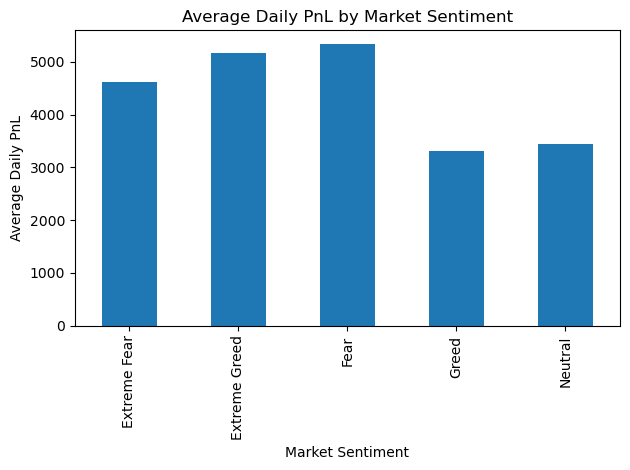

In [115]:
import os
import matplotlib.pyplot as plt

os.makedirs("outputs", exist_ok=True)

sentiment_performance.plot(
    x='sentiment',
    y='daily_pnl',
    kind='bar',
    legend=False
)

plt.title("Average Daily PnL by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Daily PnL")
plt.tight_layout()
plt.savefig("outputs/sentiment_vs_pnl.png")
plt.show()

#### **Sentiment vs Trade Frequency**

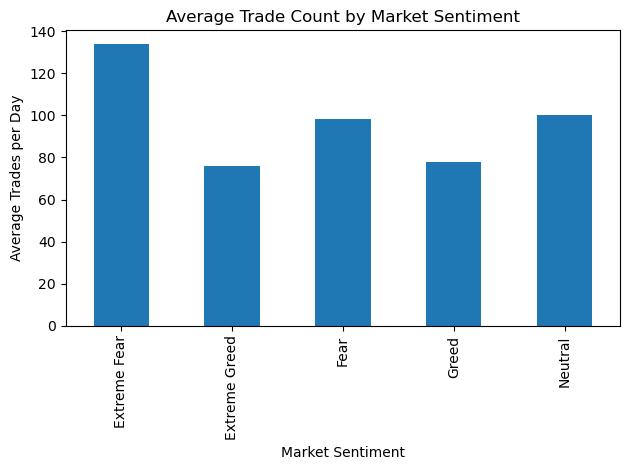

In [119]:
import os
import matplotlib.pyplot as plt

os.makedirs("outputs", exist_ok=True)

sentiment_behavior.plot(
    x='sentiment',
    y='trade_count',
    kind='bar',
    legend=False
)

plt.title("Average Trade Count by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Trades per Day")
plt.tight_layout()
plt.savefig("outputs/sentiment_vs_trade_count.png")
plt.show()

## Summary & Recommendations

### Methodology
This analysis combines historical trader-level execution data with the Bitcoin Fear & Greed Index
to study how market sentiment influences trader performance and behavior. Trade records were first
cleaned and aggregated at a daily level for each account to compute key metrics such as daily PnL,
win rate, trade frequency, average trade size, and directional bias. These daily trader metrics were
then merged with market sentiment data based on date alignment.

To better understand behavioral differences, traders were segmented into meaningful groups,
including high-frequency vs low-frequency traders (based on daily trade count) and consistent vs
inconsistent traders (based on the stability of win rates across different sentiment regimes).
Comparative analysis was performed across sentiment categories to evaluate performance and behavior
patterns. A simple logistic regression model was also explored as a baseline to assess whether
market sentiment and trading behavior can help predict profitable trading days.

---

### Key Insights
1. **Performance varies significantly with market sentiment.**  
   Traders achieve higher average daily PnL and win rates during Greed and Extreme Greed periods,
   while Fear and Extreme Fear periods are associated with lower profitability and reduced success
   rates.

2. **Trader behavior adapts to market sentiment.**  
   During Extreme Fear periods, traders tend to place more trades with smaller average position
   sizes, indicating more defensive and short-term trading behavior. In contrast, Greed-driven
   markets show fewer but larger trades, reflecting higher conviction and risk-taking.

3. **Active and consistent traders outperform others.**  
   High-frequency traders consistently outperform low-frequency traders across most sentiment
   regimes, particularly during Greed and Extreme Greed phases. Additionally, traders with more
   stable win rates across sentiment conditions demonstrate better overall performance than
   inconsistent traders.

---

### Strategy Recommendations
- **Adjust risk exposure based on market sentiment.**  
  Traders may benefit from reducing position sizes and increasing selectivity during Fear-driven
  markets, while cautiously increasing exposure during strong Greed phases.

- **Encourage disciplined, consistent trading behavior.**  
  Strategies that focus on consistency rather than short-term aggression appear to perform better
  across changing market conditions.

Overall, the findings suggest that incorporating market sentiment into trading decisions and
risk management frameworks can lead to more informed and adaptive trading strategies.